In [6]:
import numpy as np
from numpy import random
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [35]:
data_file = 'repressor_timeseries.csv'
df_data = pd.read_csv(data_file, sep='\t')

print('Dataset:')
print(df_data.head())

num_experiments = 3

#Get a 1D numpy array of x-values (repressor concentrations)
x = np.ravel(np.array(list(df_data.repressor_conc)))[::-1]
#Get a 2D matrix of measured target y-values (fluorescence). Rows are indepdendent experiments, Columns fluorescence values.
targets = np.zeros((num_experiments, len(x)))
for i in range(1, 1 + num_experiments) :
    target = np.ravel(np.array(list(df_data['fluorescence_' + str(i)])))[::-1]
    targets[i-1, :] = target

# this change to the data was made so the minization/curve fitting functions will work
# having a data point be located at true zero (0.0) introduces divide by zero errors, so having an
# otherwise equivalently zero repressor concentration (10^-8) removes this problem without
# significantly affecting the data.
x[0]=1e-8

Dataset:
   repressor_conc  fluorescence_1  fluorescence_2  fluorescence_3
0       41.152263            1683            1811            2139
1       13.717421            1818            1724            1789
2        4.572474            1863            1878            1909
3        1.524158            2301            2264            2096
4        0.508053            2329            2245            2610


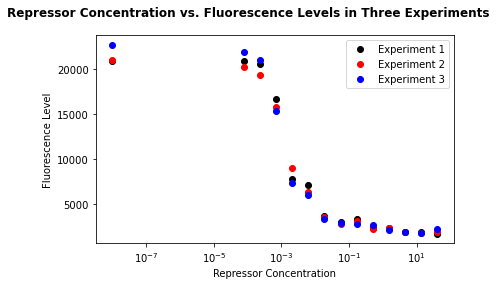

In [36]:
# x: the repressor concentrations
# targets: a 3xN matrix with the different fluorescences (targets[0] etc.)

fig, ax = plt.subplots(1)
ax.semilogx()
fluor1, = ax.plot(x, targets[0], 'o', color='black', label="Experiment 1")
ax.plot(x, targets[1], 'o', color='red', label="Experiment 2")
ax.plot(x, targets[2], 'o', color='blue', label="Experiment 3")
ax.legend()
fig.suptitle("Repressor Concentration vs. Fluorescence Levels in Three Experiments", fontweight='bold')
ax.set_xlabel("Repressor Concentration")
ax.set_ylabel("Fluorescence Level")
fig.tight_layout()

[816.50324896 672.89738362 696.10455792 546.67560968 685.75813683
 462.19692773 140.50464603  57.15670467 230.17529552 156.07761602
  89.20513189  19.15434386  39.3022476  192.03703347]


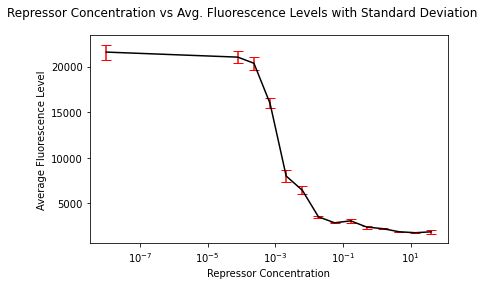

In [37]:
###
#
# Problem 2.a: Compute the mean and standard deviation of the measured values (mean fluorescence 
# and deviation between the experiments, for each data point), and plot them. Where in the 
# hill-curve, according to the data, do you see most variation?
#
###

# Temporarily transpose the array to make calculations easier.
targets = targets.T

avg_fluor = np.zeros(len(x))
std_devs = np.zeros(len(x))
for i in range(len(x)):
    avg_fluor[i] = np.mean(targets[i])
    std_devs[i] = np.std(targets[i])

targets = targets.T

print(std_devs)
fig, ax = plt.subplots(1)
ax.semilogx()
# ax.plot(x, avg_fluor, 'bo')
ax.errorbar(x=x, y=avg_fluor, yerr=std_devs, ecolor='red', color='black', capsize=5)
ax.set_xlabel("Repressor Concentration")
ax.set_ylabel("Average Fluorescence Level")
fig.suptitle("Repressor Concentration vs Avg. Fluorescence Levels with Standard Deviation")
fig.tight_layout()

    
    
    

**In what region of the hill-curve, according to the data, do you see the most variation?**

The most variation is visible when the concentration of the repressor is very low (between ~0 and 10^-3).

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_14088/1514840282.py:28: RuntimeWarning: overflow encountered in power
  return (F_max / (1 + (x / K) ** n) + F_0)
C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_14088/1514840282.py:28: RuntimeWarning: invalid value encountered in power
  return (F_max / (1 + (x / K) ** n) + F_0)


final obj: 5262.8576849863975
F_max: 19565.152387282607
n    : 1.177877031080629
K    : 0.0012911040251898727
F_0  : 2374.8306890536355
Hill Curve Equation: [F] = F_max / (1 + ([R] / K ** n) + F_0))


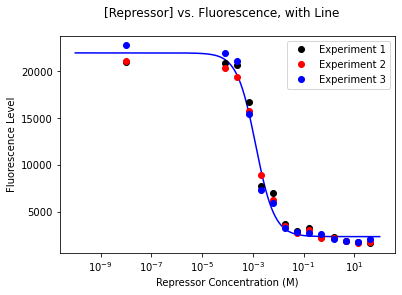

In [42]:
######################
# overall flow of this code 
# 1. 'find_optimal_coefs' uses scipy minimize to call 'objective_function' given the 'targets' data
# 2. the objective function calls the function "hill_curve" to see if minimize's
#    guesses are accurate or not.
# 
######################

###
#
# Problem 2.b: Implement the function hill_curve,
# which computes the hill-curve values of the input repressor values x (numpy array).
#
###
def hill_curve(F_max, n, K, F_0, x) :
    """Hill Curve function

    Args:
        F_max (float): maximum expression level
        n (int): Hill coefficient
        K (float): dissociation constant
        F_0 (float): leaky expression
        x (float): repressor concentration

    Returns:
        float: current expression level
    """
    return (F_max / (1 + (x / K) ** n) + F_0)

####     END OF FUNCTION 'HILL_CURVE'     ####    

###
#
# Problem 2.b: Implement the function objective_function.
# It should return the Sum-of-squared Error between target (i.e. measured) and predicted fluorescence.
# Note that in the documentation for scipy.optimize.minimize, the objective function is called "fun",
# and takes (x, *args) as arguments. The x of fun(x,*args) is equivalent to "coeff_vec", and is a 1-D array 
# containing the parameters of the function to fit: F_max, n, K, F_0 for the hill_curve function.
# 
# The *args of fun(x,*args) is a tuple of arguments. In this case, the first element of args will be the 
# input repressor values ("x"), and the second element will be the target fluorescence values ("F_x").
# The predicted fluorescence values should be computed by calling the hill_curve function you defined above.
#
#
###
def objective_function(coeff_vec, args) :
    
    x, F_x = args

    F_max = coeff_vec[0]
    n = coeff_vec[1]
    K = coeff_vec[2]
    F_0 = coeff_vec[3]
    
    # The above code was pre-written. New code is below.
    
    # 'predicted' is a 1d numpy array with values determined by the hill function 
    # for specified coefficients
    # 'x' is the 1d numpy array/vector of repressor concentrations
    predicted = hill_curve(F_max, n, K, F_0, x)
    
    objective = 0
    
    # check each experiment's value for a given repressor concentration against
    # the predicted concentration.
    for (experiment, pred) in zip(F_x, predicted):
        for val in experiment:
            objective += (val - pred) ** 2
            
    # returns the square root of the objective because otherwise the objective
    # so large that the minimization method fails.
    return np.sqrt(objective)

###
# This defines the constraints that must be satisfied by the numerical optimizer:
#
# F_max >= 0
# 0 <= n <= 5
# K >= 0
# F_0 >= 0
#
###
cons = (
    #F_max >= 0
    {'type': 'ineq',
    'fun' : lambda x: np.array([x[0]]),
    'jac' : lambda x: np.array([1, 0, 0, 0])},
    #n >= 0
    {'type': 'ineq',
    'fun' : lambda x: np.array([x[1]]),
    'jac' : lambda x: np.array([0, 1, 0, 0])},
    #n <= 5
    {'type': 'ineq',
    'fun' : lambda x: np.array([5 - x[1]]),
    'jac' : lambda x: np.array([0, -1, 0, 0])},
    #K >= 0
    {'type': 'ineq',
    'fun' : lambda x: np.array([x[2]]),
    'jac' : lambda x: np.array([0, 0, 1, 0])},
    #K BEING LESS THAN ONE WOULD BE NEW
    #K <= 1
#     {'type': 'ineq',
#     'fun' : lambda x: np.array([1 - x[2]]),
#     'jac' : lambda x: np.array([0, 0, -1, 0])},
    #F_0 >= 0
    {'type': 'ineq',
    'fun' : lambda x: np.array([x[3]]),
    'jac' : lambda x: np.array([0, 0, 0, 1])}
)


###
#
# Problem 2.b: Write code using the scipy function scipy.optimize.minimize
# to fit a hill-curve model (consisting of the 4 parameters above) to the experimental data.
# The input values are the repressor concentration values "x".
# The target (measured) values are the mean fluorescence values "F_x".
# Finally plot the fitted hill-curve in the range (0, 100]. Overlay the experimental means.
#
# Tip: The hill-curve is a highly non-linear function of the free parameters we want to fit.
# In such cases, the optimization is not guaranteed to be convex and you could end up in a bad local minima.
# Therefore it's good practice to randomly initialize the parameters.
# For example, randomly initializing n in range [0, 5] and the other parameters in range [0, 10^5].
#
###
def find_optimal_coefs(targets):
    coeff_vector = np.zeros(4, dtype=float)
    for i in range(len(coeff_vector)):
        coeff_vector[i] = random.uniform(0, 100000)
    # The second value is the hill coeff, set to random real number between 0 and 5.
    # Other variables are set to randoms between 0 and 10**5
    coeff_vector[1] = random.rand() * 5  # n

    myArgs = (x, targets.T)    
    ans = minimize(fun=objective_function, x0=coeff_vector, args=(myArgs,),
                   constraints=cons)
    
    return ans

# prints a hill curve to a new figure given the set of coefficients the 
# hill function uses ('coeff_vec') and a vector of repressor concentration ('x')
def print_hill_function(coeff_vec, x):
    F_max = coeff_vec[0]
    n = coeff_vec[1]
    K = coeff_vec[2]
    F_0 = coeff_vec[3]
    y_vals = hill_curve(F_max, n, K, F_0, x)
    fig, ax = plt.subplots(1)
    ax.semilogx()
    ax.plot(x, y_vals, color='blue')
    return fig, ax

# given a set of hill coefs, prints the appropriate hill curve on a graph
# on a top of a scatter plot of the data from the different experiments.
def print_with_data_points(hill_coefs):
    x_nums = np.logspace(start=-10, stop=2, num=10000)
    fig, ax = print_hill_function(hill_coefs, x_nums)
    ax.plot(x, targets[0], 'o', color='black', label="Experiment 1")
    ax.plot(x, targets[1], 'o', color='red', label="Experiment 2")
    ax.plot(x, targets[2], 'o', color='blue', label="Experiment 3")
    ax.legend()
    ax.set_xlabel("Repressor Concentration (M)")
    ax.set_ylabel("Fluorescence Level")
    fig.suptitle("[Repressor] vs. Fluorescence, with Line")


best_obj = 1e+30
best_coefs = np.linspace(0, 5)

# find the optimal curves 100 different times, and keep only the one with
# the best objective value. This is done because some (random) initial values
# result in a good fit, and others don't. The lowest objective value from this
# code is roughly 5262, and if that isn't found, this entire code cell 
# should be reran.
for i in range(100):
    good = find_optimal_coefs(targets)
    decent_coefs = good['x']
    myArgs = (x, targets.T)    
    if (good['success']):
        temp_obj = objective_function(decent_coefs, myArgs)
        if (temp_obj < best_obj):
            best_obj = temp_obj
            best_coefs = decent_coefs
            
# Below is output to the console regarding the curve that was found.            
print("final obj: " + str(best_obj))

F_maxb = best_coefs[0]
nb = best_coefs[1]
Kb = best_coefs[2]
F_0b = best_coefs[3]

print("F_max: " + str(best_coefs[0]))
print("n    : " + str(best_coefs[1]))
print("K    : " + str(best_coefs[2]))
print("F_0  : " + str(best_coefs[3]))
print("Hill Curve Equation: [F] = F_max / (1 + ([R] / K ** n) + F_0))")
# create the graph with the curve and the data points from the experiments
print_with_data_points(best_coefs)   
